In [1]:
import os
import numpy as np
import pandas as pd
import random
import itertools
import pickle
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm

from numpy.random import RandomState
from sklearn.utils import shuffle

import argparse
import seaborn as sns

In [2]:
unix_path = os.path.normpath(os.getcwd()).replace("\\", "/")

print(unix_path)  # Output: C:/Users/Example/Documents/file.txt

C:/Users/aghalkha21/Downloads/Git_Projects/Multimodal


In [4]:
###############################################
#### Input dataset name
###############################################
root_folder = '../Carla/datasets/scenario23_dev/'
data_csv = root_folder + 'scenario23.csv'




###############################################
# Read dataset to create a list of the input sequence   
###############################################

df = pd.read_csv(data_csv)
image_data_lst = df['unit1_rgb'].values
pwr_data_lst = df['unit1_pwr_60ghz'].values
#original_beam = df['unit1_beam_index'].values


###############################################
#### subsample the power and generate the 
#### updated beam indices
###############################################
updated_beam = []
original_beam = []
for entry in tqdm(pwr_data_lst):
    data_to_read = f'./{root_folder}{entry[1:]}'
    pwr_data = np.loadtxt(data_to_read)
    original_beam.append(np.argmax(pwr_data)+1)
    updated_pwr = []
    j = 0
    while j < (len(pwr_data)- 1):
        tmp_pwr = pwr_data[j]
        updated_pwr.append(tmp_pwr)
        j += 2
    updated_beam.append(np.argmax(updated_pwr)+1)
    






100%|██████████| 11387/11387 [04:14<00:00, 44.73it/s]


In [5]:
def create_img_beam_dataset():   
    
    folder_to_save = 'image_beam'
    if not os.path.exists(folder_to_save):
        os.makedirs(folder_to_save)
    
    #############################################
    ###### created updated image path ###########
    #############################################
    updated_img_path = []
    print("Creating the image based dataset")
    for entry in tqdm(image_data_lst):
        img_path = entry.split('./')[1]
        img_path_abs = os.path.normpath(os.path.abspath(img_path)).replace('\\', '/')
        updated_path = f'./{root_folder}/{img_path}'
        updated_img_path.append(updated_path)
    
    
    #############################################
    # saving the image-beam development dataset for training and validation
    #############################################
                            
    indx = np.arange(1, len(updated_beam)+1,1)
    df_new = pd.DataFrame()
    df_new['index'] = indx   
    df_new['unit1_rgb'] = updated_img_path   
    df_new['unit1_beam'] = updated_beam    
    df_new.to_csv(fr'./{folder_to_save}/scenario23_img_beam.csv', index=False)       
      
    #############################################
    #generate the train and test dataset
    #############################################    
    rng = RandomState(1)
    train, val, test = np.split(df_new.sample(frac=1, random_state=rng ), [int(.6*len(df_new)), int(.9*len(df_new))])
    train.to_csv(f'./{folder_to_save}/scenario23_img_beam_train.csv', index=False)
    val.to_csv(f'./{folder_to_save}/scenario23_img_beam_val.csv', index=False)
    test.to_csv(f'./{folder_to_save}/scenario23_img_beam_test.csv', index=False)


def create_pos_beam_dataset():  
    
    folder_to_save = './pos_beam'
    if not os.path.exists(folder_to_save):
        os.makedirs(folder_to_save)
    
    ###############################################
    ####### read position values from dataset #####
    ###############################################

    lat = []
    lon = []
    pos_data_path = df['unit2_loc'].values
    print("Creating the position based dataset")
    print("Reading the dataset")
    for entry in tqdm(pos_data_path):
        data_to_read = f'./{root_folder}{entry[1:]}'
        pos_val = np.loadtxt(data_to_read)
        #lat_val, lon_val = pos_val[0], pos_val[1]
        lat.append(pos_val[0])
        lon.append(pos_val[1])
        
    def norm_data(data_lst):
        norm_data = []
        for entry in data_lst:
            norm_data.append((entry - min(data_lst))/(max(data_lst) - min(data_lst)))
        return norm_data

    ###############################################
    ##### normalize latitude and longitude data ###
    ###############################################
    lat_norm = norm_data(lat)
    lon_norm = norm_data(lon)

    ###############################################
    ##### generate final pos data #################
    ###############################################
    pos_data = []
    for j in range(len(lat_norm)):
        pos_data.append([lat_norm[j], lon_norm[j]])


    #############################################
    # saving the pos-beam development dataset for training and validation
    #############################################
                            
    indx = np.arange(1, len(updated_beam)+1,1)
    df_new = pd.DataFrame()
    df_new['index'] = indx   
    df_new['unit2_pos'] = pos_data   
    df_new['unit1_beam'] = updated_beam    
    df_new.to_csv(fr'./{folder_to_save}/scenario23_pos_beam.csv', index=False) 
    
    #############################################
    #generate the train and test dataset
    #############################################    
    rng = RandomState(1)
    train, val, test = np.split(df_new.sample(frac=1, random_state=rng ), [int(.6*len(df_new)), int(.9*len(df_new))])
    train.to_csv(f'./{folder_to_save}/scenario23_pos_beam_train.csv', index=False)
    val.to_csv(f'./{folder_to_save}/scenario23_pos_beam_val.csv', index=False)
    test.to_csv(f'./{folder_to_save}/scenario23_pos_beam_test.csv', index=False)






create_img_beam_dataset()
#create_pos_beam_dataset()

Creating the image based dataset


100%|██████████| 11387/11387 [00:00<00:00, 76045.03it/s]
C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
def create_pos_height_beam_dataset():  
    
    folder_to_save = './pos_height_beam'
    if not os.path.exists(folder_to_save):
        os.makedirs(folder_to_save)
    
    ###############################################
    ####### read position values from dataset #####
    ###############################################

    lat = []
    lon = []
    height = []
    distance = []
    
    pos_data_path = df['unit2_loc'].values
    height_data_path = df['unit2_height'].values
    distance_data_path = df['unit2_distance'].values
    print("Creating the position based dataset")
    print("Reading the dataset")
    for entry in tqdm(pos_data_path):
        
        data_to_read = f'./{root_folder}{entry[1:]}'
        pos_val = np.loadtxt(data_to_read)
        #lat_val, lon_val = pos_val[0], pos_val[1]
        lat.append(pos_val[0])
        lon.append(pos_val[1])
        
    for entry_height, entry_distance in zip(tqdm(height_data_path), distance_data_path) :
        data_to_read_height = f'./{root_folder}{entry_height[1:]}'
        data_to_read_distance = f'./{root_folder}{entry_distance[1:]}'
        
        height_val = np.loadtxt(data_to_read_height)
        distance_val = np.loadtxt(data_to_read_distance)
        height.append(height_val)
        distance.append(distance_val)
        
        
    def norm_data(data_lst):
        norm_data = []
        for entry in data_lst:
            norm_data.append((entry - min(data_lst))/(max(data_lst) - min(data_lst)))
        return norm_data

    ###############################################
    ##### normalize latitude and longitude data ###
    ###############################################
    lat_norm = norm_data(lat)
    lon_norm = norm_data(lon)
    height_norm = norm_data(height)
    distance_norm = norm_data(distance)
    ###############################################
    ##### generate final pos data #################
    ###############################################
    #pos_data = []
    #for j in range(len(lat_norm)):
    #    pos_data.append([lat_norm[j], lon_norm[j]])


    #############################################
    # saving the pos-beam development dataset for training and validation
    #############################################
                            
    indx = np.arange(1, len(updated_beam)+1,1)
    df_new = pd.DataFrame()
    df_new['index'] = indx   
    df_new['unit2_lat'] = lat_norm
    df_new['unit2_lon'] = lon_norm
    df_new['unit2_height'] = height_norm
    df_new['unit2_distance'] = distance_norm
    df_new['unit1_beam'] = updated_beam    
    df_new.to_csv(fr'./{folder_to_save}/scenario23_pos_height_beam.csv', index=False) 
    
    #############################################
    #generate the train and test dataset
    #############################################    
    rng = RandomState(1)
    train, val, test = np.split(df_new.sample(frac=1, random_state=rng ), [int(.6*len(df_new)), int(.9*len(df_new))])
    train.to_csv(f'./{folder_to_save}/scenario23_pos_height_beam_train.csv', index=False)
    val.to_csv(f'./{folder_to_save}/scenario23_pos_height_beam_val.csv', index=False)
    test.to_csv(f'./{folder_to_save}/scenario23_pos_height_beam_test.csv', index=False)   



create_pos_height_beam_dataset()

Creating the position based dataset
Reading the dataset


100%|██████████| 11387/11387 [03:43<00:00, 50.89it/s]
C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
pos_path = "./pos_height_beam/scenario23_pos_height_beam.csv"
images_path = "./image_beam/scenario23_img_beam.csv"
pos_dataset = pd.read_csv(pos_path)
image_dataset = pd.read_csv(images_path)

In [8]:
pos_dataset.describe()


,index,unit2_lat,unit2_lon,unit2_height,unit2_distance,unit1_beam
count,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000
mean,5694.000000,0.342214,0.395211,0.318174,0.288409,15.227013
std,3287.288092,0.151951,0.115469,0.264798,0.169777,4.918251
min,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2847.500000,0.230261,0.342666,0.092153,0.173748,14.000000
50%,5694.000000,0.309431,0.410203,0.204380,0.238590,16.000000
75%,8540.500000,0.398631,0.448638,0.535584,0.368189,17.000000
max,11387.000000,1.000000,1.000000,1.000000,1.000000,30.000000


In [9]:
concat_data = pd.merge(pos_dataset, image_dataset, left_index=True, right_index=True)
concat_data = concat_data.drop(columns=["unit1_beam_y", "index_y"])

# Function to swap two columns
def swap_columns(df, col1, col2):
    cols = list(df.columns)
    idx1, idx2 = cols.index(col1), cols.index(col2)
    cols[idx1], cols[idx2] = cols[idx2], cols[idx1]
    return df[cols]

# Swap columns 'A' and 'C'
concat_data = swap_columns(concat_data, 'unit1_beam_x', 'unit1_rgb')

In [10]:
concat_data.count()

index_x           11387
unit2_lat         11387
unit2_lon         11387
unit2_height      11387
unit2_distance    11387
unit1_rgb         11387
unit1_beam_x      11387
dtype: int64

       unit2_lat  unit2_lon lat_region lon_region  region
0       0.319556   0.487488          1          1       3
1       0.317678   0.486797          1          1       3
2       0.316038   0.486105          1          1       3
3       0.314589   0.485414          1          1       3
4       0.312354   0.484446          1          1       3
...          ...        ...        ...        ...     ...
11382   0.330251   0.421678          1          1       3
11383   0.330014   0.421678          1          1       3
11384   0.329824   0.421678          1          1       3
11385   0.329348   0.421817          1          1       3
11386   0.329229   0.421955          1          1       3

[11387 rows x 5 columns]


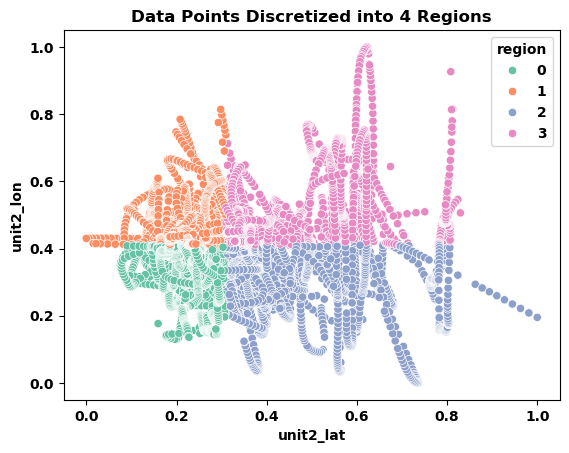

In [11]:
# Discretize Feature 1 into two regions: '0' and '1'
feature1_threshold = concat_data['unit2_lat'].median()  # Median as the splitting point
concat_data['lat_region'] = pd.cut(
    concat_data['unit2_lat'],
    bins=[concat_data['unit2_lat'].min() - 1, feature1_threshold, concat_data['unit2_lat'].max() + 1],
    labels=[0, 1]
)

# Discretize Feature 2 into two regions: '0' and '1'
feature2_threshold = concat_data['unit2_lon'].median()  # Median as the splitting point
concat_data['lon_region'] = pd.cut(
    concat_data['unit2_lon'],
    bins=[concat_data['unit2_lon'].min() - 1, feature2_threshold, concat_data['unit2_lon'].max() + 1],
    labels=[0, 1]
)

# Combine the two regions to define the final 4 regions
concat_data['region'] = (concat_data['lat_region'].astype(int) * 2 + concat_data['lon_region'].astype(int)).astype(int)

# Display the dataset
print(concat_data[['unit2_lat', 'unit2_lon', 'lat_region', 'lon_region', 'region']])

# Visualize the regions
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=concat_data, x='unit2_lat', y='unit2_lon', hue='region', palette='Set2')
plt.title("Data Points Discretized into 4 Regions")
plt.xlabel("unit2_lat")
plt.ylabel("unit2_lon")
plt.show()

C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


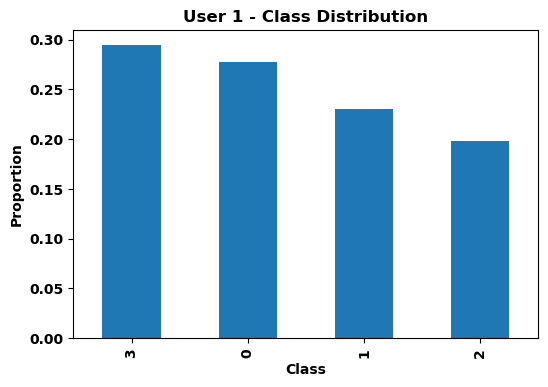

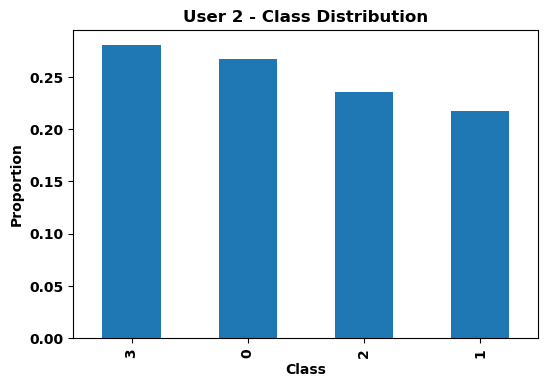

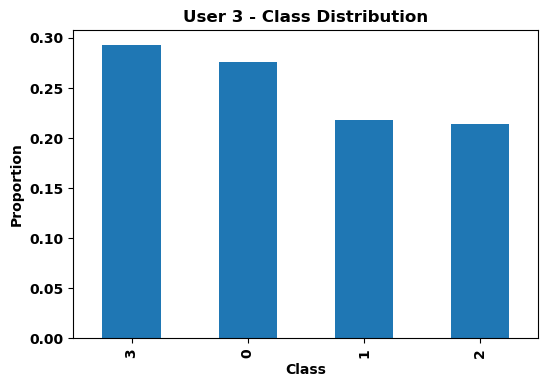

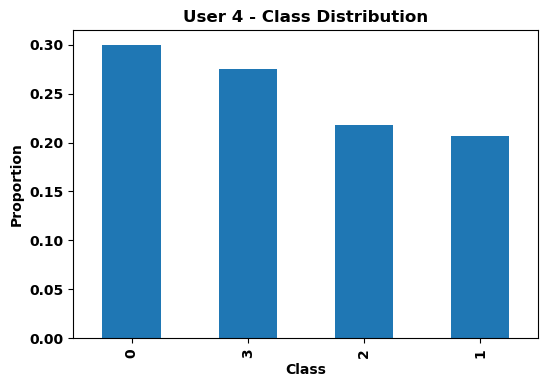

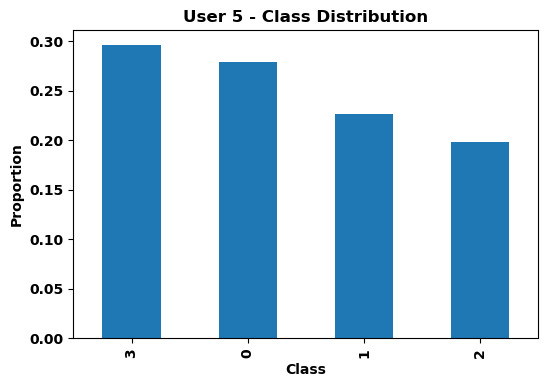

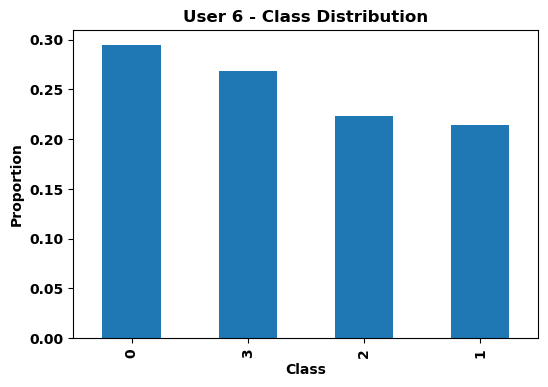

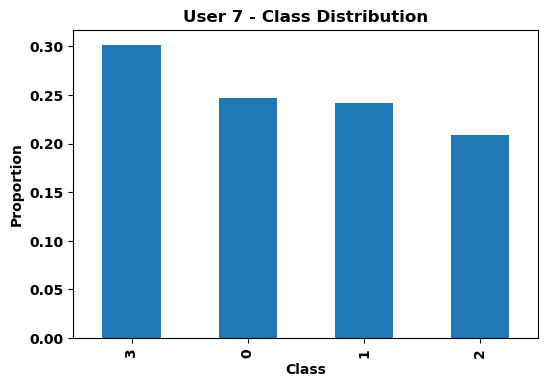

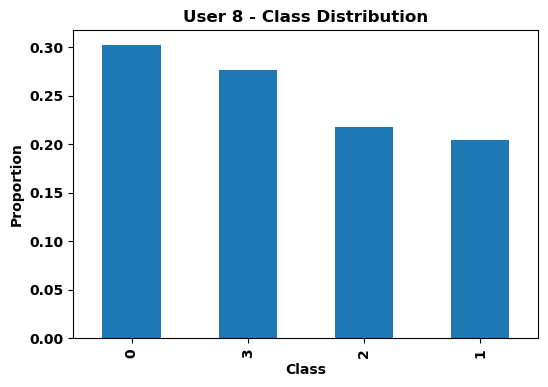

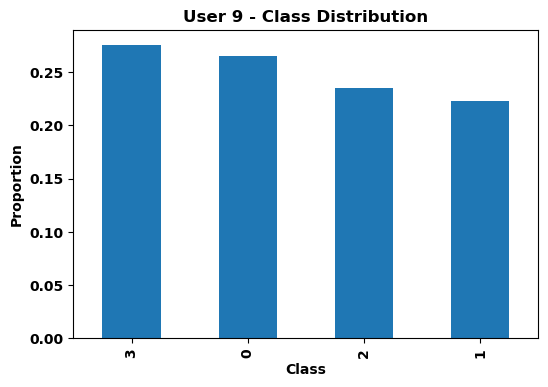

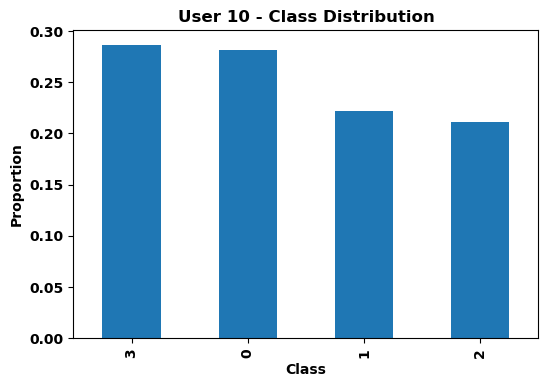

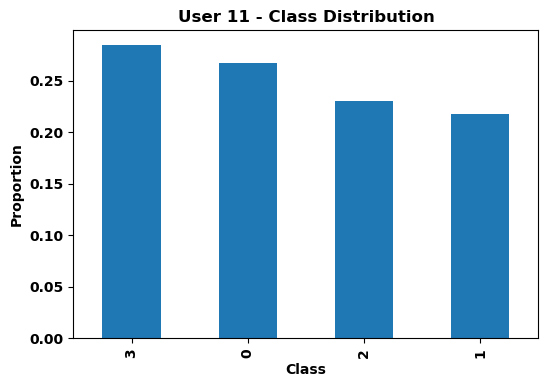

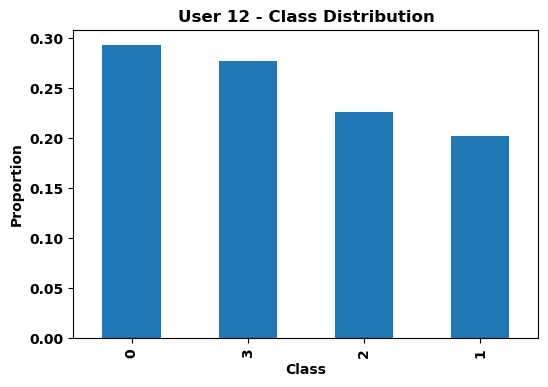

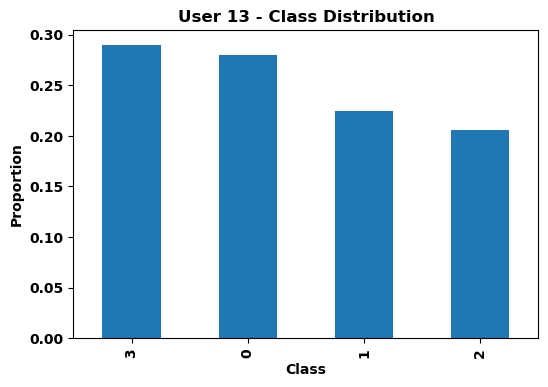

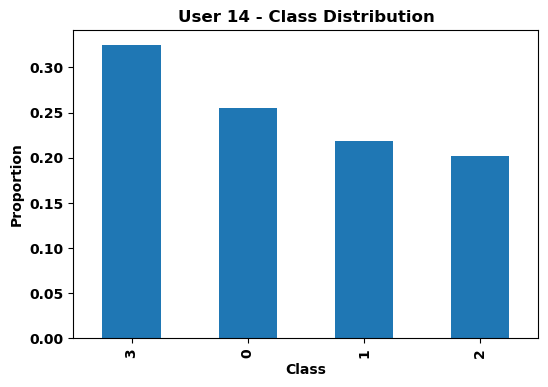

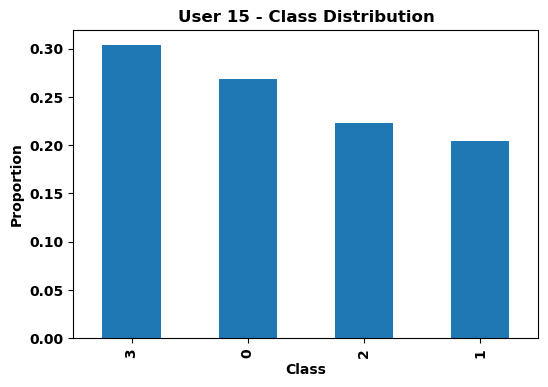

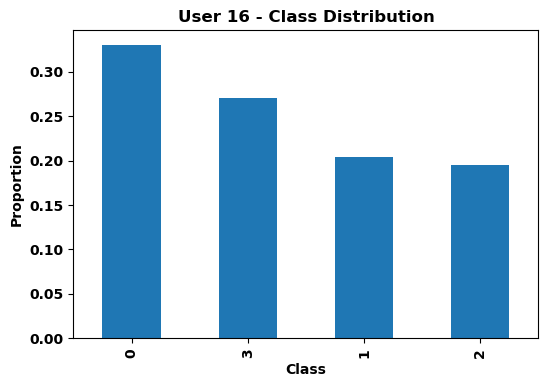

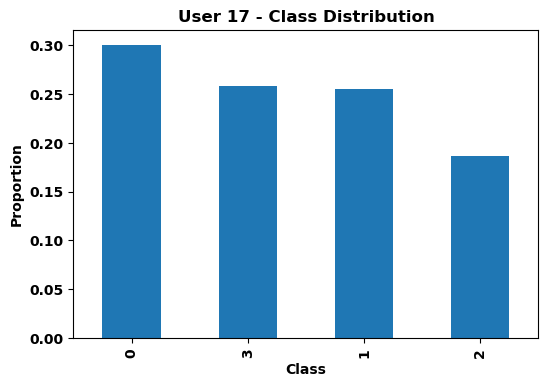

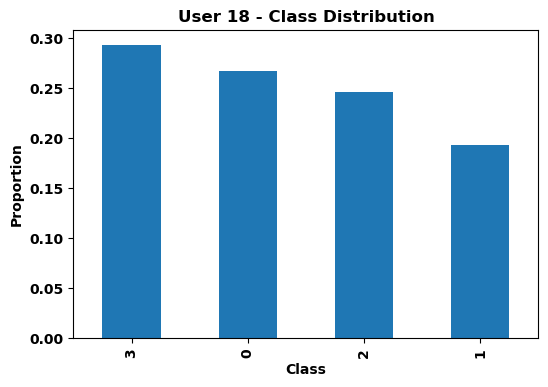

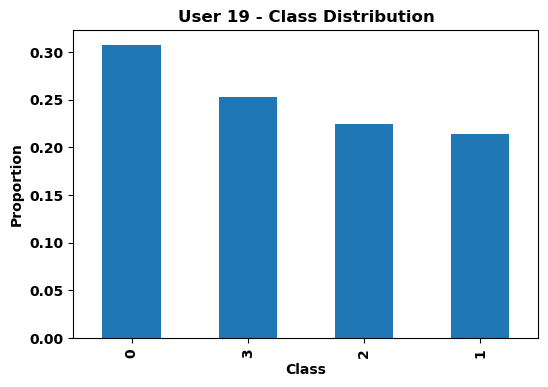

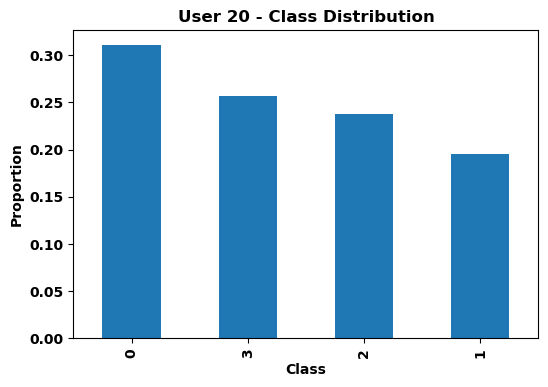

C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed i

In [12]:
import numpy as np
import pandas as pd
import os
from numpy.random import RandomState

# Example dataset (Replace with actual dataset)
df = concat_data  # Your actual DataFrame

# Number of users
num_users = 20

# Shuffle the dataset randomly
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split data equally into `num_users` parts
user_dfs = np.array_split(df, num_users)

# ✅ Visualization: Check if class distribution is consistent across users
import matplotlib.pyplot as plt

for i, user_df in enumerate(user_dfs):
    plt.figure(figsize=(6, 4))
    user_df['region'].value_counts(normalize=True).plot(kind='bar', title=f"User {i+1} - Class Distribution")
    plt.xlabel('Class')
    plt.ylabel('Proportion')
    plt.show()

# ✅ Save user datasets
save_directory = "./feature_IID/"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

rng = RandomState(1)

for i, user_df in enumerate(user_dfs):
    user_df.to_csv(f'{save_directory}/user_{i}_pos_height_beam.csv', index=False)
    
    # Split into train (60%), val (30%), test (10%)
    train, val, test = np.split(
        user_df.sample(frac=1, random_state=rng),
        [int(.6 * len(user_df)), int(.9 * len(user_df))]
    )

    train.to_csv(f'{save_directory}/user_{i}_pos_height_beam_train.csv', index=False)
    val.to_csv(f'{save_directory}/user_{i}_pos_height_beam_val.csv', index=False)
    test.to_csv(f'{save_directory}/user_{i}_pos_height_beam_test.csv', index=False)


C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_9564\1984461553.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  user_dfs[user_idx] = pd.concat([user_dfs[user_idx], class_data.iloc[start_idx:start_idx + num_samples]])
C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_9564\1984461553.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  user_dfs[user_idx] = pd.concat([user_dfs[user_idx], class_data.iloc[start_idx:start_idx + num_samples]])
C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_9564\

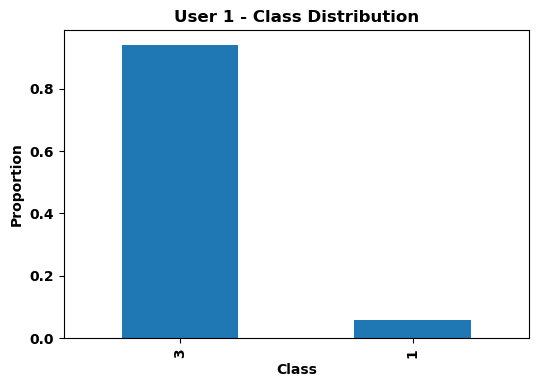

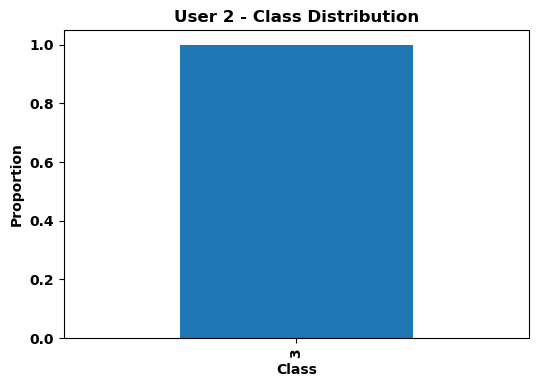

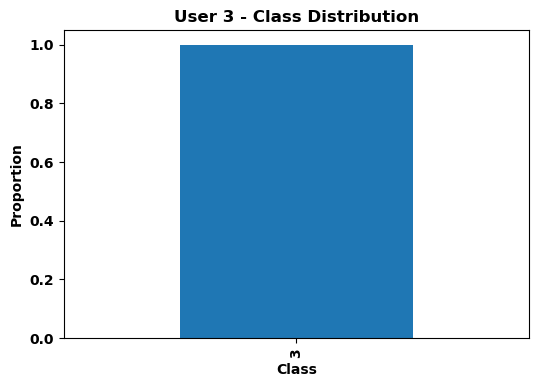

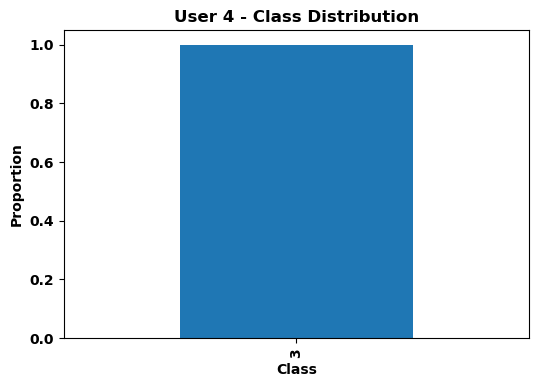

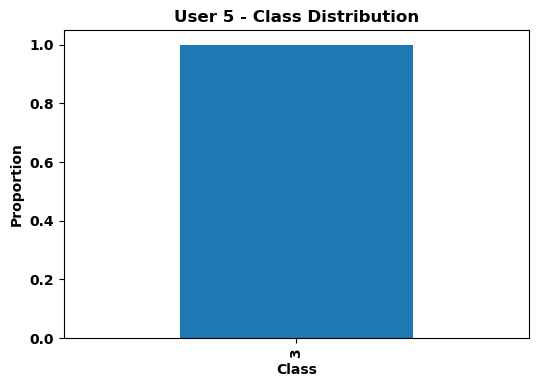

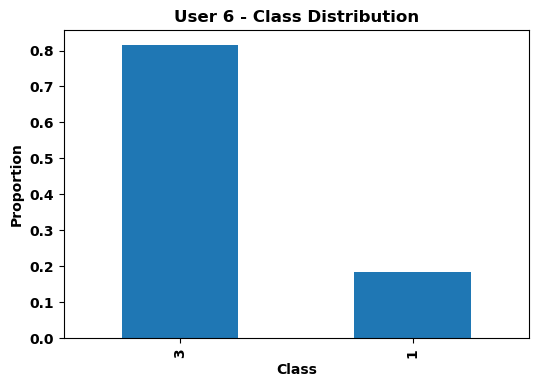

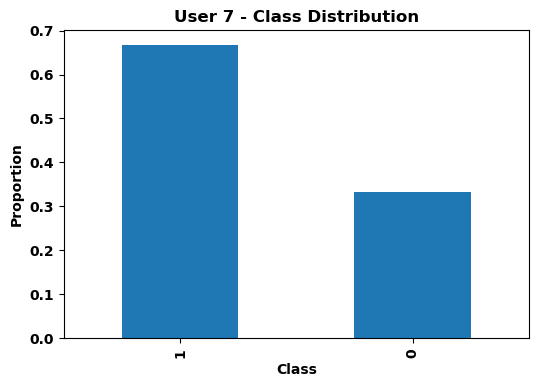

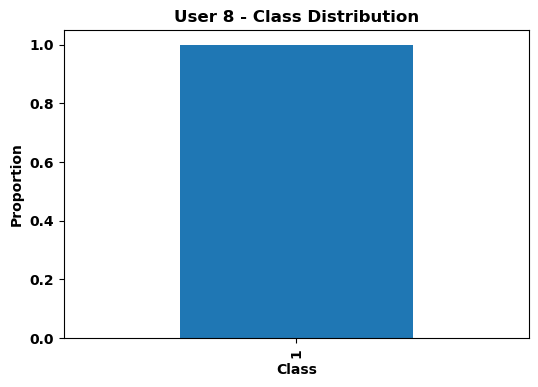

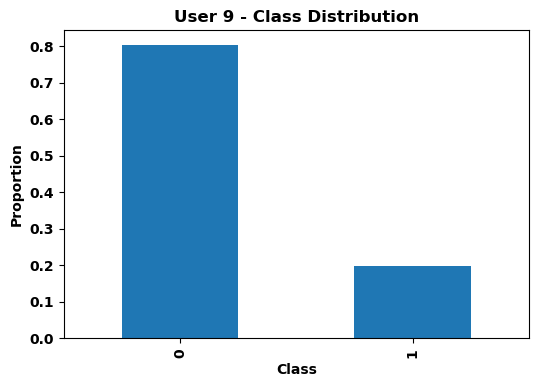

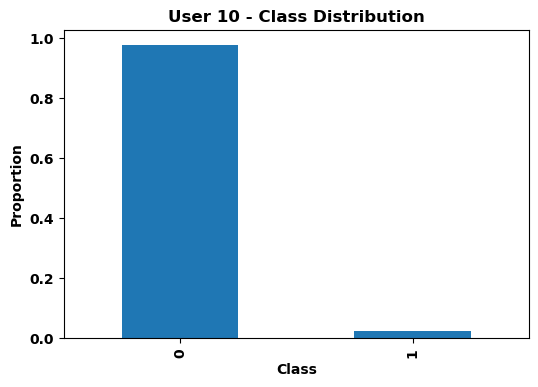

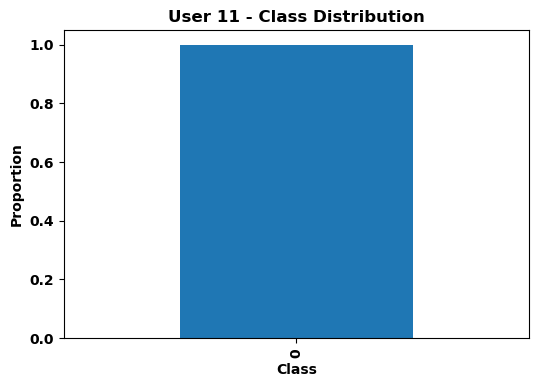

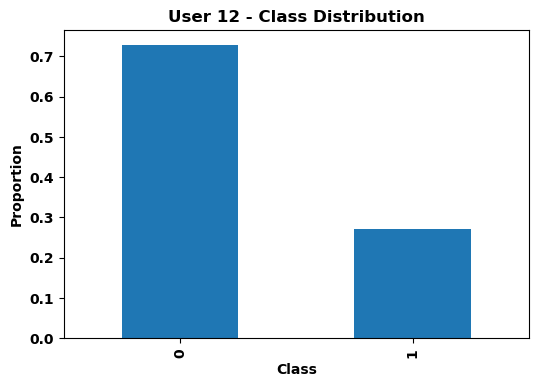

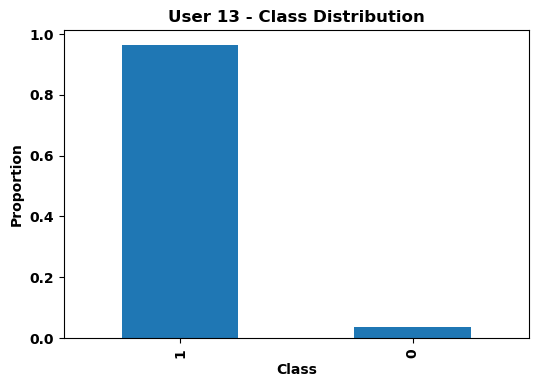

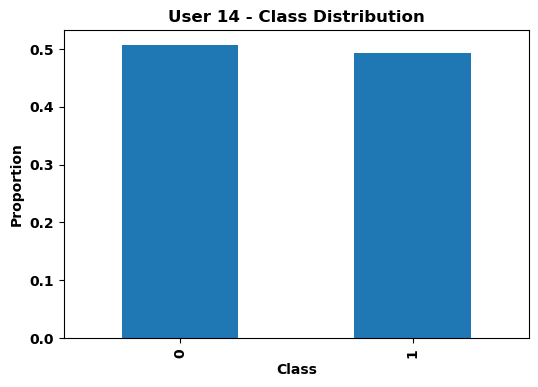

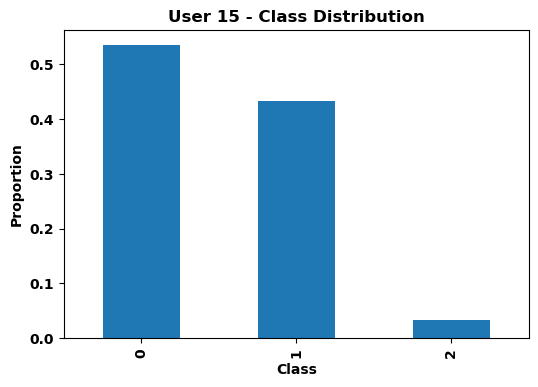

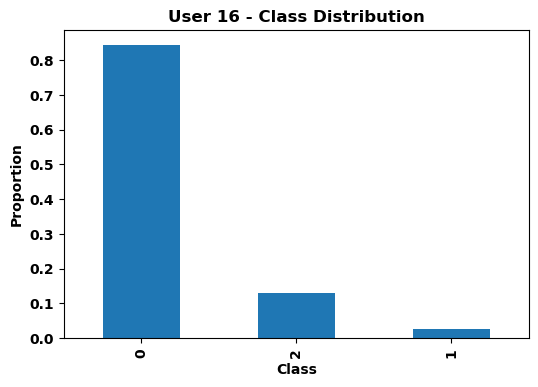

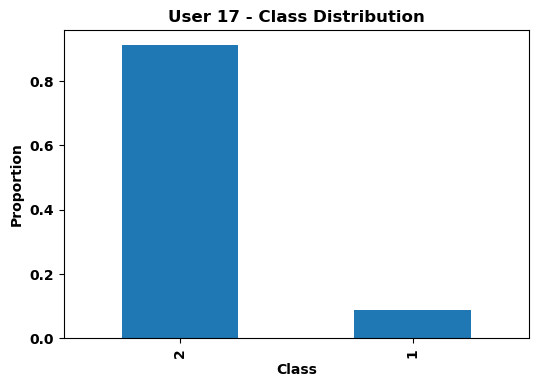

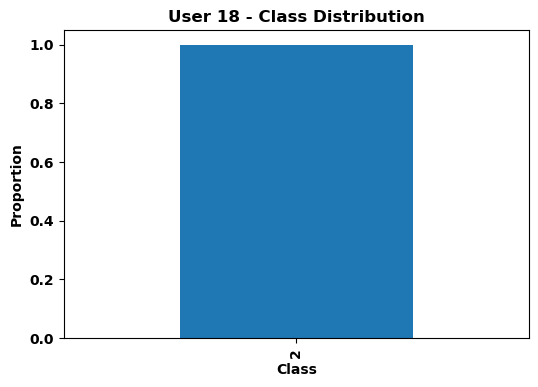

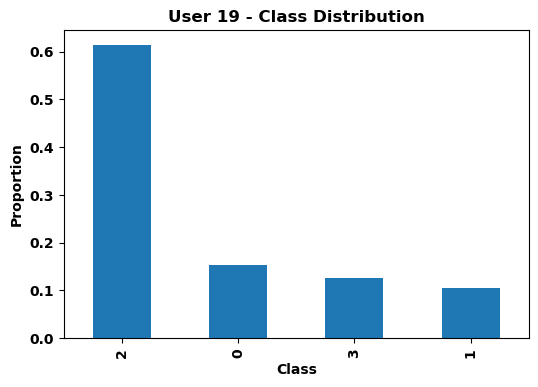

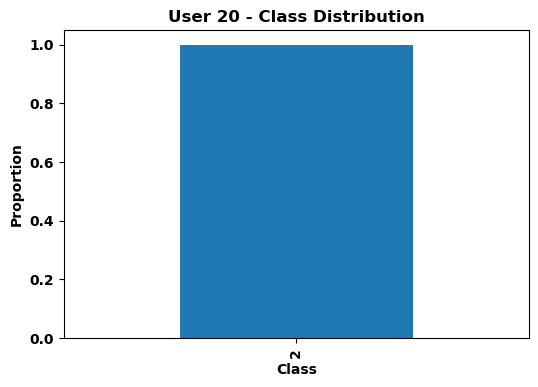

C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\aghalkha21\AppData\Local\anaconda3\envs\fmtl_sheaves\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed i

In [13]:
import numpy as np
import pandas as pd
import os
from scipy.stats import dirichlet
import matplotlib.pyplot as plt
from numpy.random import RandomState

# Example dataset (Replace with actual dataset)
df = concat_data  # Your actual DataFrame

# Number of users
num_users = 20

# Number of classes
num_classes = len(df['region'].unique())

# Dirichlet parameter (α) - controls heterogeneity
alpha = 0.5  # Lower α → More non-IID, Higher α → More IID

# Maximum number of samples per user
max_samples_per_user = 560

# Generate Dirichlet-distributed probabilities for user-class proportions
user_class_probs = dirichlet.rvs([alpha] * num_classes, size=num_users)

# Group data by class
class_samples = {cls: df[df['region'] == cls] for cls in df['region'].unique()}

# Initialize empty DataFrames for each user
user_dfs = {i: pd.DataFrame(columns=df.columns) for i in range(num_users)}

# First pass: Assign initial data based on Dirichlet probabilities
for class_idx, (cls, class_data) in enumerate(class_samples.items()):
    num_samples_in_class = len(class_data)

    # Compute number of samples per user for this class
    user_allocations = (user_class_probs[:, class_idx] * num_samples_in_class).astype(int)

    # Shuffle class data
    class_data = class_data.sample(frac=1, random_state=42).reset_index(drop=True)

    start_idx = 0
    for user_idx, num_samples in enumerate(user_allocations):
        if len(user_dfs[user_idx]) >= max_samples_per_user:
            continue  # Skip if user already has 560 samples
        
        # Adjust to avoid exceeding 560 samples
        available_space = max_samples_per_user - len(user_dfs[user_idx])
        num_samples = min(num_samples, available_space)

        if num_samples > 0:
            user_dfs[user_idx] = pd.concat([user_dfs[user_idx], class_data.iloc[start_idx:start_idx + num_samples]])
        
        start_idx += num_samples

# ✅ Ensure Every User Has Exactly 560 Samples by Sampling Directly
for user_idx in range(num_users):
    while len(user_dfs[user_idx]) < max_samples_per_user:
        needed_samples = max_samples_per_user - len(user_dfs[user_idx])
        
        # Sample additional data from full dataset
        extra_samples = df.sample(n=needed_samples, replace=True, random_state=42)
        
        user_dfs[user_idx] = pd.concat([user_dfs[user_idx], extra_samples])

# ✅ Final Check: Ensure All Users Have Exactly 560 Samples
for i in range(num_users):
    assert len(user_dfs[i]) == max_samples_per_user, f"User {i} does not have 560 samples!"

# ✅ Visualization: Check class distribution per user
for i, user_df in user_dfs.items():
    plt.figure(figsize=(6, 4))
    user_df['region'].value_counts(normalize=True).plot(kind='bar', title=f"User {i+1} - Class Distribution")
    plt.xlabel('Class')
    plt.ylabel('Proportion')
    plt.show()

# ✅ Save non-IID user datasets
save_directory = "./feature_nonIID/"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

rng = RandomState(1)

for i, user_df in user_dfs.items():
    user_df.to_csv(f'{save_directory}/user_{i}_pos_height_beam.csv', index=False)
    
    # Split into train (60%), val (30%), test (10%)
    train, val, test = np.split(
        user_df.sample(frac=1, random_state=rng),
        [int(.6 * len(user_df)), int(.9 * len(user_df))]
    )

    train.to_csv(f'{save_directory}/user_{i}_pos_height_beam_train.csv', index=False)
    val.to_csv(f'{save_directory}/user_{i}_pos_height_beam_val.csv', index=False)
    test.to_csv(f'{save_directory}/user_{i}_pos_height_beam_test.csv', index=False)


In [14]:
total = 0
for i in range(20):
    dataframe = pd.read_csv(f'./{save_directory}/user_{i}_pos_height_beam.csv')
    print(len(dataframe))

560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
560
